# Installing desired version of fastai - pytorch

In [0]:
!pip install fastai==1.0.54 > /dev/null

# Setting up Environment to get reproducible results

[** Didn't set num_workers as 1]

Ref : https://docs.fast.ai/dev/test.html#getting-reproducible-results

In [0]:
seed = 42

# python RNG
import random
random.seed(seed)

# pytorch RNGs
import torch
torch.manual_seed(seed)
torch.backends.cudnn.deterministic = True
if torch.cuda.is_available(): torch.cuda.manual_seed_all(seed)

# numpy RNG
import numpy as np
np.random.seed(seed)

# Loading required packages

(Some packages can be removed, as I have carried out other operations that are not part of this release)

In [0]:
import torch.nn as nn

import torch
import torch.nn as nn
import torch.nn.functional as F
import shutil as sh
import os

from fastai.layers import *
from fastai.torch_core import *

from fastai.vision import *
from fastai.callbacks.csv_logger import CSVLogger
from fastai.callbacks.hooks import *

torch.backends.cudnn.benchmark = True

from fastai.torch_core import *
from fastai.callback import *
from fastai.callbacks import *
from fastai.basic_train import *
from fastai.basic_data import *

# Downloading CIFAR100 Dataset

In [0]:
path = untar_data(URLs.CIFAR_100)

# Parameters and Dataloader

In [0]:
bs = 128
epochs = 50
metrics = [accuracy, error_rate, top_k_accuracy]

loss_func = nn.CrossEntropyLoss()

base_lr = 0.1
momentum= 0.9
w_decay = 0.0001

opt_func = partial (optim.SGD, momentum=0.9)

result_path = '/content/sample_data/activation/results/'
final_path = "/content/drive/'My Drive'/activation/"

In [0]:
ds_tfms = ([ *rand_pad(4, 32), flip_lr(p=0.5)], [])
data = ImageDataBunch.from_folder(path, valid='test', bs=bs ,ds_tfms = ds_tfms , val_bs =100).normalize(cifar_stats)

# Modified NIN network

Official Implementation

https://gist.github.com/mavenlin/e56253735ef32c3c296d#file-solver-prototxt

Our implementation is based on 

https://github.com/jiecaoyu/pytorch-nin-cifar10

In [0]:
class Net(nn.Module):
  def __init__(self):
    super(Net, self).__init__()
    self.num_classes = 100
    self.classifier = nn.Sequential(
                      nn.Conv2d(3, 192, kernel_size=5, stride=1, padding=2),
                      nn.ReLU(inplace=True),
        
                      nn.Conv2d(192, 160, kernel_size=1, stride=1, padding=0),
                      nn.ReLU(inplace=True),
        
                      nn.Conv2d(160,  96, kernel_size=1, stride=1, padding=0),
                      nn.ReLU(inplace=True),
        
                      nn.MaxPool2d(kernel_size=3, stride=2, padding=1),
                      nn.Dropout(0.5),

                      nn.Conv2d(96, 192, kernel_size=5, stride=1, padding=2),
                      nn.ReLU(inplace=True),
        
                      nn.Conv2d(192, 192, kernel_size=1, stride=1, padding=0),
                      nn.ReLU(inplace=True),
        
                      nn.Conv2d(192, 192, kernel_size=1, stride=1, padding=0),
                      nn.ReLU(inplace=True),
        
                      nn.AvgPool2d(kernel_size=3, stride=2, padding=1),
                      nn.Dropout(0.5),

                      nn.Conv2d(192, 192, kernel_size=3, stride=1, padding=1),
                      nn.ReLU(inplace=True),
        
                      nn.Conv2d(192, 192, kernel_size=1, stride=1, padding=0),
                      nn.ReLU(inplace=True),
        
                      nn.Conv2d(192,  self.num_classes , kernel_size=1, stride=1, padding=0),
                      nn.ReLU(inplace=True),
        
                      nn.AvgPool2d(kernel_size=8, stride=1, padding=0),
                      )

  def forward(self, x):
    x = self.classifier(x)
    x = x.view(x.size(0), self.num_classes)
    return x

In [0]:
class Rank_Activations(HookCallback):
    "Callback that record the mean and std of activations."
    stats= []
    
    def on_train_begin(self, **kwargs):
        "Initialize stats."
        super().on_train_begin(**kwargs)
        self.stats = []
        self.num = 0

    def hook(self, m:nn.Conv2d, i:Tensors, o:Tensors)->Tuple[Rank0Tensor,Rank0Tensor]:
        "Take the mean and std of `o`."
        self.num = self.num + 1
        if isinstance(m, nn.Conv2d):
          res = o.mean().item()
          return res
          #print(m)
        else:
          #res = None
          pass
      
    def on_batch_end(self, train, **kwargs):
        "Take the stored results and puts it in `self.stats`"
        if (not train): self.stats.append(self.hooks.stored)
          
    def on_train_end(self, **kwargs):
        "Polish the final result."
        super().on_train_end(**kwargs)
        self.stats = (self.stats)

# Initializing weights and bias

In [0]:
model = Net()
# model.cuda()

pretrained=False
if pretrained:
    params = pickle.load(open('data/params', 'r'))
    index = -1
    for m in model.modules():
        if isinstance(m, nn.Conv2d):
            index = index + 1
            weight = torch.from_numpy(params[index])
            m.weight.data.copy_(weight)
            index = index + 1
            bias = torch.from_numpy(params[index])
            m.bias.data.copy_(bias)
else:
    for m in model.modules():
        if isinstance(m, nn.Conv2d):
            m.weight.data.normal_(0, 0.05)
            m.bias.data.normal_(0, 0.0)


# Splitting Model into sections for discriminative learning

In [0]:
learn = Learner(data, model, loss_func= loss_func, opt_func = opt_func ,metrics=metrics).mixup()

In [0]:
learn.split([[ learn.model.classifier[0:20]], [learn.model.classifier[20] ]])

Learner(data=ImageDataBunch;

Train: LabelList (50000 items)
x: ImageList
Image (3, 32, 32),Image (3, 32, 32),Image (3, 32, 32),Image (3, 32, 32),Image (3, 32, 32)
y: CategoryList
flatfish,flatfish,flatfish,flatfish,flatfish
Path: /root/.fastai/data/cifar100;

Valid: LabelList (10000 items)
x: ImageList
Image (3, 32, 32),Image (3, 32, 32),Image (3, 32, 32),Image (3, 32, 32),Image (3, 32, 32)
y: CategoryList
flatfish,flatfish,flatfish,flatfish,flatfish
Path: /root/.fastai/data/cifar100;

Test: None, model=Net(
  (classifier): Sequential(
    (0): Conv2d(3, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU(inplace)
    (2): Conv2d(192, 160, kernel_size=(1, 1), stride=(1, 1))
    (3): ReLU(inplace)
    (4): Conv2d(160, 96, kernel_size=(1, 1), stride=(1, 1))
    (5): ReLU(inplace)
    (6): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (7): Dropout(p=0.5)
    (8): Conv2d(96, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (9):

# Decalring Step Dropout as Callback

[Not used in this notebook]


In [0]:
class Drop_Activations(LearnerCallback):
  train_flag = False
  
  def on_train_begin(self, **kwargs):
    "Initialize stats."
    super().on_train_begin(**kwargs)
    self.train_flag = True
    
  def on_epoch_begin(self, **kwargs):
    if (self.train_flag):
      epoch_num = kwargs['epoch']
      epoch_tot = kwargs['n_epochs']

      child = children(self.model)[0]
      for item in child:
        if isinstance(item, nn.Dropout):
          item.p = (epoch_num  / epoch_tot) * 0.5

  def on_train_end(self, **kwargs):
    "Initialize stats."
    super().on_train_begin(**kwargs)
    self.train_flag = False

# Declaring Curriculum Line  dropout

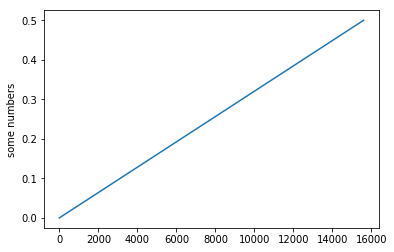

In [0]:
# Params as per paper
""" 
keep_prob_input: _prob_input,   #0.9
keep_prob_conv : _prob_conv,    #0.75
keep_prob_fc   : _prob_fc       #0.5
"""

import numpy as np

gamma = 0.001
p = 0.5 


def line_drop(x):
  return (x / (40 * 390)) * p

def schedule_dropout(x):
    val = (1.0 - p) * np.exp(- gamma * x ) + p
    return val

#     val = -(1.-p)* np.exp(- gamma * x) + 1 # Default. 
#     This is value set to keep_prob in TF. 
#     In case of pytorch it refers to probability to make zero
def Anneal_dropout(x):
    val =    (1.-p)* np.exp(- gamma * x)
    return val

# 40  refers to number of epochs
# 390 refers to (number of train images / (batch_size))
j = []
for i in range(0,40 * 390):  
  j.append(line_drop(i))

num_iter = 390

import matplotlib.pyplot as plt
plt.plot(j)
plt.ylabel('some numbers')
plt.show()

In [0]:
class Curriculum_Dropout(LearnerCallback):
    "Curriculum Dropout Callback"
    count = 0
    train_flag = False
    
    def on_train_begin(self, **kwargs):
        "Initialize stats."
        super().on_train_begin(**kwargs)
        self.train_flag = True
        self.count = 0

    def on_batch_begin(self, train, **kwargs):
        "Take the stored results and puts it in `self.stats`"
        if (train): 
          self.count += 1; 
          child = children(self.model)[0]
          for item in child:
            if isinstance(item, nn.Dropout):
              item.p = line_drop(kwargs['iteration'])
          
    def on_train_end(self, **kwargs):
        "Polish the final result."
        super().on_train_end(**kwargs)
        self.count = 0

# Using the curriculum line drop in this notebook

In [0]:
# learn.callbacks += [ Drop_Activations(learn) ]
learn.callbacks += [ Rank_Activations(learn) ]
learn.callbacks += [ Curriculum_Dropout(learn) ]

# Running the Network

In [0]:
epochs =40
learn.fit( epochs ,  lr= (1 * base_lr , 0.1 * base_lr) , wd = (2 * w_decay , 1 *w_decay))

epoch,train_loss,valid_loss,accuracy,error_rate,top_k_accuracy,time
0,4.457010,4.407050,0.038200,0.961800,0.151000,00:39
1,4.269063,4.121736,0.076700,0.923300,0.247100,00:39
2,4.116526,3.953439,0.095900,0.904100,0.302100,00:38
3,3.971855,3.686150,0.132000,0.868000,0.375600,00:38
4,3.844726,3.446853,0.165200,0.834800,0.437800,00:38
5,3.688110,3.269913,0.190000,0.810000,0.487800,00:38
6,3.562614,3.147001,0.217900,0.782100,0.520100,00:39
7,3.454859,3.004339,0.255000,0.745000,0.567000,00:39
8,3.357899,2.804860,0.292600,0.707400,0.608800,00:39
9,3.217531,2.596706,0.342900,0.657100,0.659300,00:39


# Result

In [0]:
learn.validate()

[1.6216741, tensor(0.5645), tensor(0.4355), tensor(0.8377)]

# Best Results

[Obtained during trial run. I hope the variation is minimal across multiple runs]


>  train_loss --------------------------------- 2.461889

> valid_loss --------------------------------- 1.599115

> accuracy ---------------------------------- 0.5712

> error_rate --------------------------------- 0.4288

> top_k_accuracy ----------------------- 0.8442	